## PH21 Assignment 5

In [1]:
######################################################
#                                                    #
#  Do not commit cache/data files to the repository  #
#                                                    #
######################################################

### In this assignment, you will need to do the following:

1. Determine the error bars on event count datasets
2. Use a collection of events to statistically test if a particle exists given a data channel
3. Fit a model of the particle and background events. Then test against a model with only the background events
3. Determine the likelihood that a particle exists using the errorbars generated from the event dataset.


Background
===========
In the previous assignments (including some of ph20) we have manipulated and fit against datasets where we have either ignored errorbars or had them given to us. Here we must determine the statistical error, given typical "counting statistics" present in all manner of physics experiments, though perhaps most prominently in High Energy Physics experiments using particle colliders.

motivating liturature:

If you are interested in some recent discoveries, take a look at the discovery of tetraquarks from LHCb: https://www.nature.com/articles/s41567-022-01614-y and its figure data at https://www.hepdata.net/record/114871. 

The figure to stare at is https://www.nature.com/articles/s41567-022-01614-y/figures/1.

similarly, look at a recent discovery of a Higgs boson decay channel through Z-gamma decays, https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.132.021803. There, look at Figure 2 https://journals.aps.org/prl/article/10.1103/PhysRevLett.132.021803/figures/2/medium. A more complete history of its detection is given in https://pdg.lbl.gov/2022/reviews/rpp2022-rev-higgs-boson.pdf, which has many more similar plots.

What do both of these analysis have in common? The datasets are essentially plotting a Probability Distribution of event decays. What does that mean? Well a collider only sees the results of a collition as a big collection of resulting particles, their energy and their momentum (via where in the detector they were sensed). From data about the particles detected, various analysis methods "reconstruct" intermediate particles that led to the final observations. 

In the first paper, those intermediate observations were D- and Pi- Mesons. In the second paper, those were a pair of Z-boson and gamma (photon) particles. In both, the total energy of those particular choices of intermediate particles is plotted against the *rate* that events at that energy is seen. New particles tend to create an excess of events at an energy corresponding to the mass of the particle. The trick is to determine what choice of intermediates best detects it. We will assume those things, and just try to perform the detection, given a set of particle event data.

OK.... so how is that done? Well once those particles were reconstructed, essentially they were just put into a big histogram over the total energy of the resulting particles. By using simulation tools, the histograms for Higgs vs. No-higgs or tetra vs. no-tetra could be determined. 

With the data histogrammed, it then becomes a hypothesis test to determine which reality is the most likely. Likelihood is a statistical way of saying "in which reality is the observed data more probable."  

We will explore this using some simple examples, before looking at a dataset that mimics this Higgs channel discovery. I call it that since the Higgs was already discovered, but this newer result is a particularly clean example. 



In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
#import mplhep as hep
import h5py as h5

Load the hdf5 dataset in collision_data.h5. Use h5py. The command line tool "h5ls -R file.h5" can be useful to explore, but you can also use python.

The data is a set of arrays forming a table of collision events. They are split into the individual particles recognized in the collider.

In [4]:
f = h5.File('collision_data.h5', 'r')

In [5]:
datasets = list(f.keys())

Make some preliminary histograms to explore the dataset. Transform the dataset into a histogram of the total collision energy. You can use your physics knowledge to try to further filter the data an remove backgrounds (the dataset was made "imperfect" so that there are some additional ways to distinguish background from events.). Further filtering is not necessary, but interesting to further reduce noise.

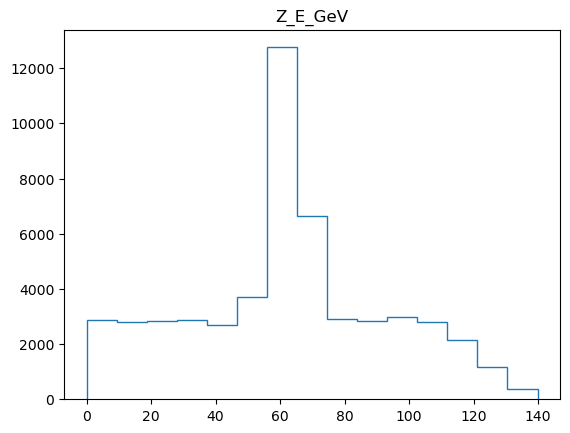

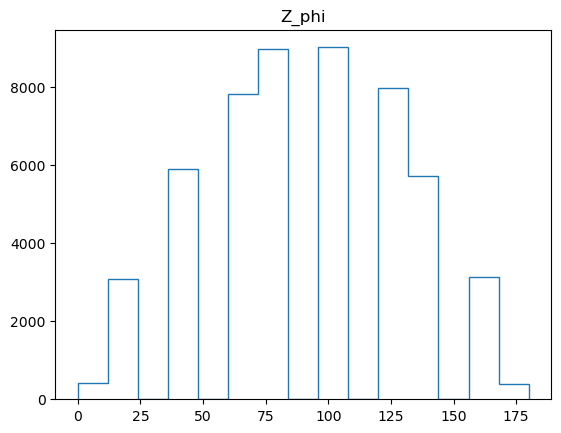

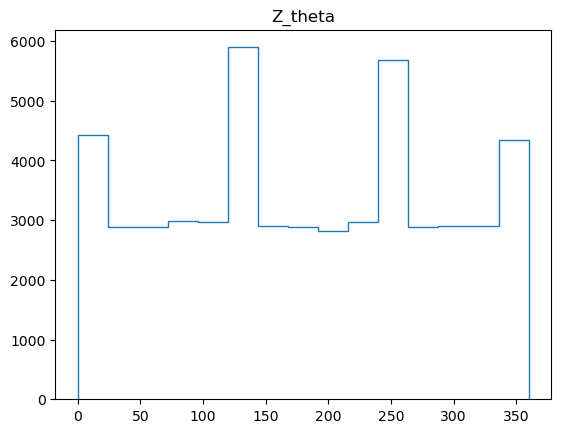

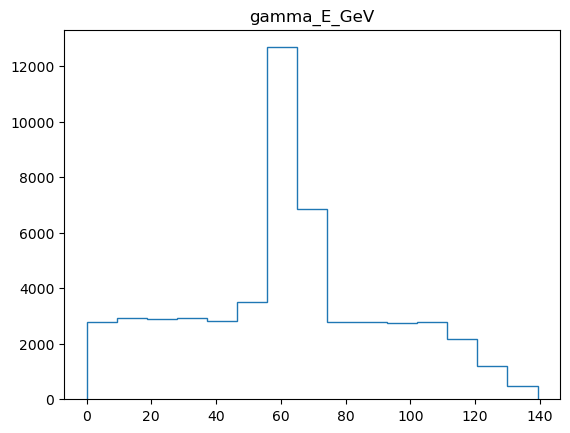

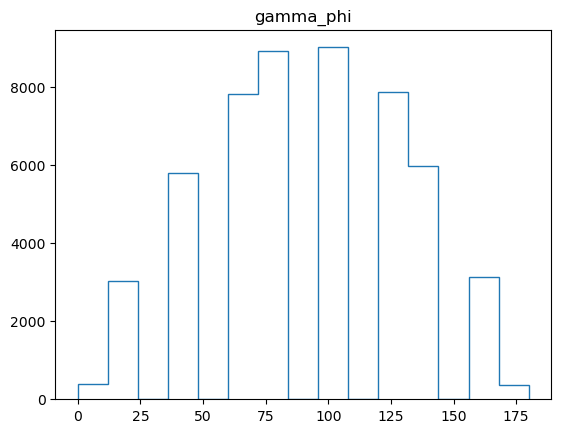

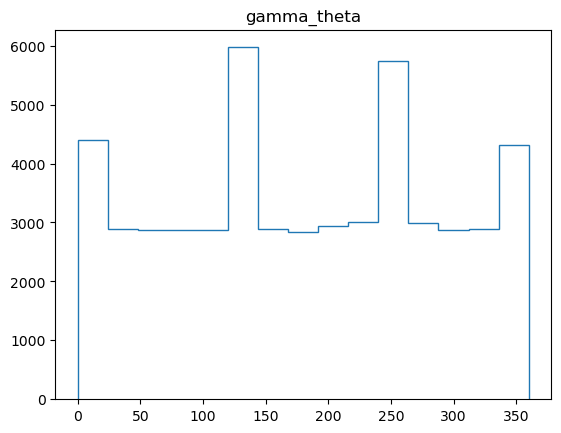

In [6]:
# make histograms of each individual particle
for key in f.keys():
    data = f[key][:]
    fig, ax = plt.subplots()
    plt.hist(data, bins=15, histtype='step')
    plt.title(key)


In [7]:
file_path = "collision_data.h5"
data_dict = {}
with h5.File(file_path, "r") as h5file:
    for dataset in datasets:
        data_dict[dataset] = h5file[dataset][:]

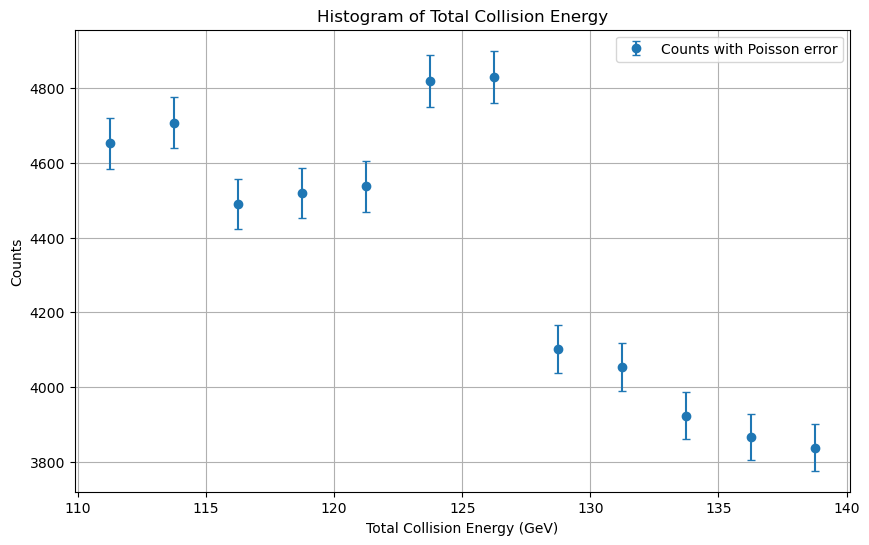

In [ ]:
total_energy = data_dict["Z_E_GeV"] + data_dict["gamma_E_GeV"]
bin_width = 2.5 # I tried different bin widths and this one seemed to work the best
bins = np.arange(total_energy.min(), total_energy.max() + bin_width, bin_width)
counts, bin_edges = np.histogram(total_energy, bins=bins)

errors = np.sqrt(counts)

plt.figure(figsize=(10, 6))
plt.errorbar(bin_edges[:-1] + bin_width / 2, counts, yerr=errors, fmt='o', capsize=3, label="Counts with Poisson error")
plt.xlabel("Total Collision Energy (GeV)")
plt.ylabel("Counts")
plt.title("Histogram of Total Collision Energy")
plt.grid(True)
plt.legend()
plt.show()

Make a histogram in units of counts, and add the errorbars associated with Poisson counting error. You get to choose the binning you like. Explore the interactive example plots. Should the choice of binning matter?

In [19]:
# the historgram in units of counts for the total energy is shown above.
# The choice of binning is arbitrary, but the bin width is chosen to be 5 GeV, which matters because if the bin width is too small, we will get too scattered data points, and if the bin width is too large, we will lose information. The error bars are calculated using Poisson statistics as well, dependent on the counts in each bin, which depends on how large the bin we use.

now calibrate the histogram and its errorbars into event rate units. This means cross-section per GeV of detected energy. The dataset was taken over an integrated luminosity of 
L = 150 fb^-1. That unit is inverse femto-barns. Yes, the barn is a unit of area in physics. It looks like a small area, but it is considered a large cross section. That means that every individual event in the dataset has a cross section of 1/L, and when you accumulate N of them, the cross section of the "pool" of events is N/L.

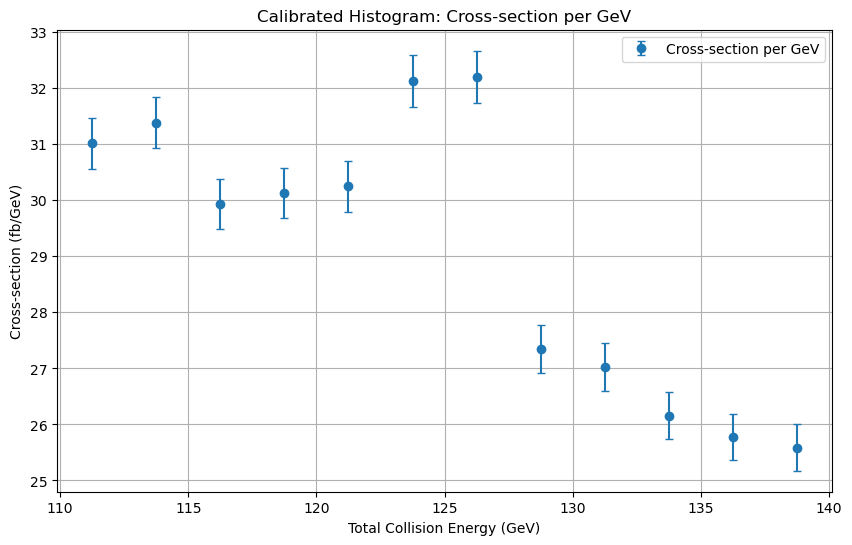

In [61]:
L = 150  # fb^-1

cross_section_per_GeV = counts / L  # σ = N / L
cross_section_error = errors / L  

plt.figure(figsize=(10, 6))
plt.errorbar(bin_edges[:-1] + bin_width / 2, cross_section_per_GeV, yerr=cross_section_error, fmt='o', capsize=3, label="Cross-section per GeV")
plt.xlabel("Total Collision Energy (GeV)")
plt.ylabel("Cross-section (fb/GeV)")
plt.title("Calibrated Histogram: Cross-section per GeV")
plt.grid(True)
plt.legend()
plt.show()

Now create a model background and event process. The background can be a rate in the Lorenzian tail of many low-energy processes

$R_{bg}(E) = R_{scale} * \frac{E_{scale}}{E}$

$R_{higgs}(E) = \frac{1}{\pi}\frac{\Delta E}{\Delta E^2 + (E - mc^2)^2}$ 

$R_{joint}(E) = R_{bg}(E) + (A*B)*R_{higgs}(E)$

Where A is the Higgs formation cross section (units of area) and B is an unknown representing the branching ratio into the Higgs measurement channel of interest. Note that this measurement can only measure the product, so you can call that $C=(A \cdot B)$ which is the cross section for the $Z\gamma$ decay channel. $\Delta E$ in principle measures the lifetime/energy width of the Higgs, but here is limited by the resolution of the detection system, which smears out the event energies.

You will then create residuals by subtracting the data from the model and weighting by the error bars. Use scipy.optimize.least_squares to fit the unknown parameters of both the particle and backgrounds.

Perform this minimization twice, once using the joint rate, and once using a rate with only the background.

Plot all of these things together, and print all of the parameters.


Question: This fit leads to very weird behavior /best parameters if I don't give physical constraints, so I ended up giving a few constraints.

In [62]:
# background model R_bg(E)
def R_bg(E, R_scale, E_scale):
    return R_scale * (E_scale / E)

# Higgs resonance model R_higgs(E)
def R_higgs(E, Delta_E, mc2):
    return (1 / np.pi) * (Delta_E / (Delta_E**2 + (E - mc2)**2))

In [63]:
E_centers = bin_edges[:-1] + bin_width / 2

In [64]:
def residuals_bg(params, E, observed, errors):
    R_scale, E_scale = params
    model = R_bg(E, R_scale, E_scale)
    return (observed - model) / errors

In [65]:
initial_params_bg = [10, 10]

In [66]:
import scipy.optimize as opt
# fit background-only model
bg_fit = opt.least_squares(residuals_bg, initial_params_bg, args=(E_centers, cross_section_per_GeV, cross_section_error))
best_params_bg = bg_fit.x

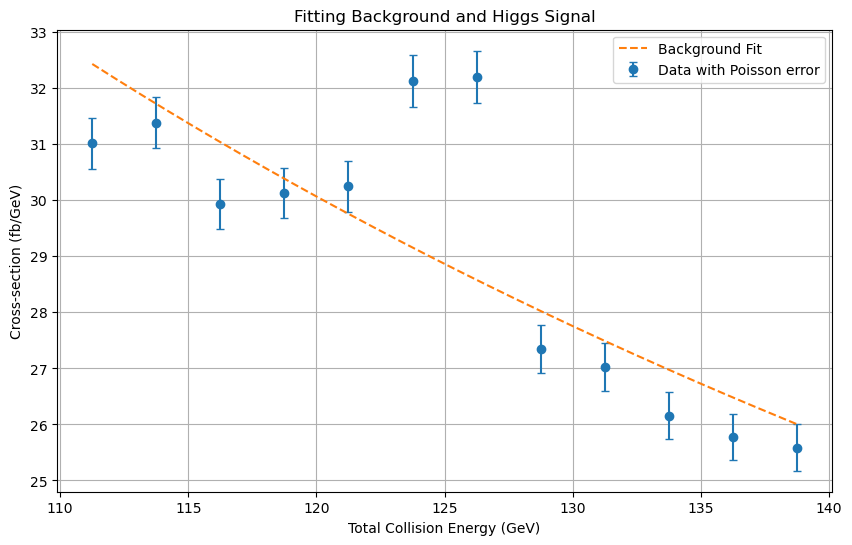

In [67]:
E_fit = np.linspace(min(E_centers), max(E_centers), 500)
bg_curve = R_bg(E_fit, *best_params_bg)

plt.figure(figsize=(10, 6))
plt.errorbar(E_centers, cross_section_per_GeV, yerr=cross_section_error, fmt='o', label="Data with Poisson error", capsize=3)
plt.plot(E_fit, bg_curve, label="Background Fit", linestyle="dashed")
plt.xlabel("Total Collision Energy (GeV)")
plt.ylabel("Cross-section (fb/GeV)")
plt.title("Fitting Background and Higgs Signal")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
bg_best_fit_results = {
    "Background Model": {
        "R_scale": best_params_bg[0],
        "E_scale": best_params_bg[1],
    }
}

bg_best_fit_results

{'Background Model': {'R_scale': 67.04103210269179,
  'E_scale': 53.821087859930294}}

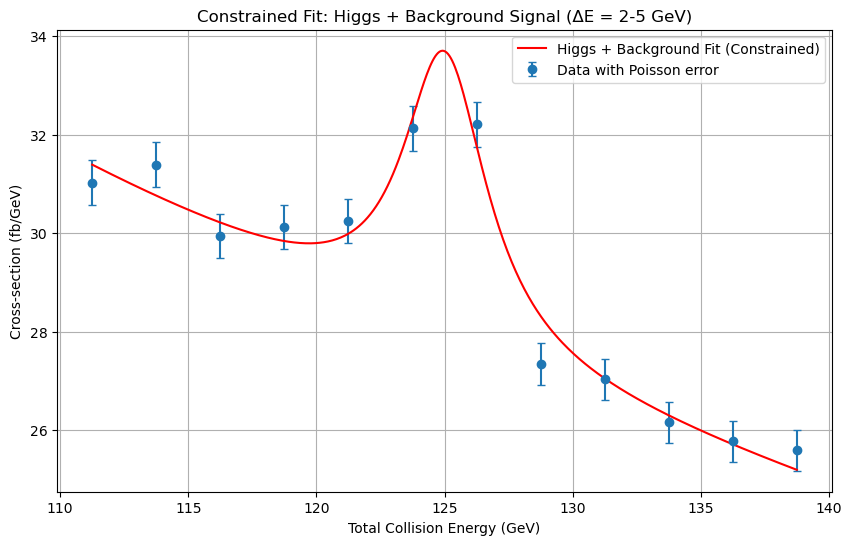

Best-Fit Parameters (Constrained Model):
{'R_scale': 37.03623235618562, 'E_scale': 93.92342959255276, 'C (Higgs Cross-Section × Branching Ratio)': 36.86332481870886, 'Delta_E (Resolution)': 2.0000000000000004, 'mc2 (Higgs Mass)': 125}


In [69]:
# joint model with Higgs + background
def R_joint(E, R_scale, E_scale, C, Delta_E):
    mc2 = 125  # Fix Higgs mass at 125 GeV
    return R_bg(E, R_scale, E_scale) + C * R_higgs(E, Delta_E, mc2)

# residuals for the constrained fit
def residuals_joint(params, E, observed, errors):
    R_scale, E_scale, C, Delta_E = params
    model = R_joint(E, R_scale, E_scale, C, Delta_E)
    return (observed - model) / errors

initial_params_joint = [10, 10, 1, 3]  # R_scale, E_scale, C, Delta_E (start with ΔE=3 GeV)

# define bounds
lower_bounds = [0, 0, 0, 2]  # force C > 0, ΔE > 2 GeV
upper_bounds = [np.inf, np.inf, np.inf, 5]  # limit ΔE to 5 GeV

joint_fit_constrained = opt.least_squares(
    residuals_joint, initial_params_joint,
    args=(E_centers, cross_section_per_GeV, cross_section_error),
    bounds=(lower_bounds, upper_bounds)
)

best_params_constrained = joint_fit_constrained.x
best_params_constrained_dict = {
    "R_scale": best_params_constrained[0],
    "E_scale": best_params_constrained[1],
    "C (Higgs Cross-Section × Branching Ratio)": best_params_constrained[2],
    "Delta_E (Resolution)": best_params_constrained[3],
    "mc2 (Higgs Mass)": 125,  # Fixed value
}

E_fit = np.linspace(min(E_centers), max(E_centers), 500)
joint_curve_constrained = R_joint(E_fit, *best_params_constrained)

plt.figure(figsize=(10, 6))
plt.errorbar(E_centers, cross_section_per_GeV, yerr=cross_section_error, fmt='o', label="Data with Poisson error", capsize=3)
plt.plot(E_fit, joint_curve_constrained, label="Higgs + Background Fit (Constrained)", linestyle="solid", color="red")
plt.xlabel("Total Collision Energy (GeV)")
plt.ylabel("Cross-section (fb/GeV)")
plt.title("Constrained Fit: Higgs + Background Signal (ΔE = 2-5 GeV)")
plt.legend()
plt.grid(True)
plt.show()

print("Best-Fit Parameters (Constrained Model):")
print(best_params_constrained_dict)


Now get the array of residuals for both fits. This array has a statistical interpretation. Each data point represents a random variable. In the low-N limit, this variable has a binomial distribution. If you used very fine binning, you may have to consider that. For course binning, the N in each bit is large, N>30, where the central limit theorem kicks in and the Binomial distribution can be approximated as a Gaussian with a standard deviation equal to the error bar. Since the residuals are normalized by the error bar, they should look like standard normal distributions.

Histogram the residuals of each fit and check that they appear Gaussian distributed with the correct scaling. (You could in principle put error bars on this histogram too.. and that is useful to test the Guassianaity of your noise process. No need here). This is a very standard data quality test to check an error model

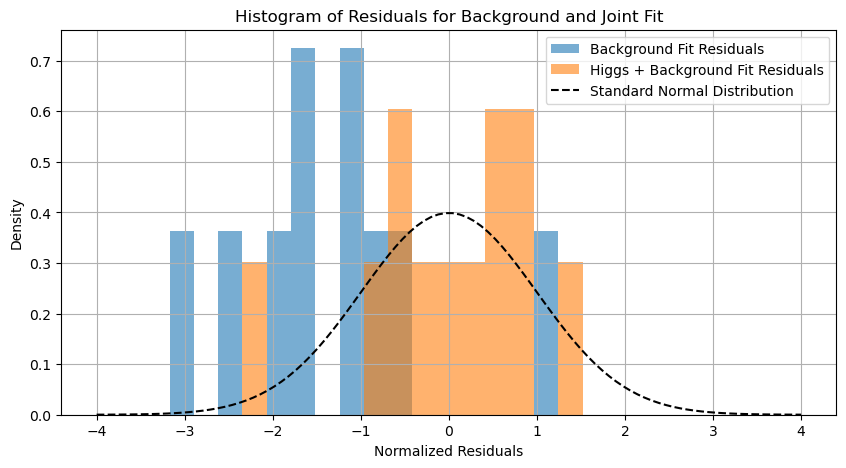

In [ ]:
residuals_bg_values = residuals_bg(best_params_bg, E_centers, cross_section_per_GeV, cross_section_error)

residuals_joint_values = residuals_joint(best_params_constrained, E_centers, cross_section_per_GeV, cross_section_error)

residual_bins = np.linspace(-4, 4, 30)  


plt.figure(figsize=(10, 5))
plt.hist(residuals_bg_values, bins=residual_bins, alpha=0.6, label="Background Fit Residuals", density=True)
plt.hist(residuals_joint_values, bins=residual_bins, alpha=0.6, label="Higgs + Background Fit Residuals", density=True)

x_norm = np.linspace(-4, 4, 100)
y_norm = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x_norm**2)
plt.plot(x_norm, y_norm, 'k--', label="Standard Normal Distribution")

plt.xlabel("Normalized Residuals")
plt.ylabel("Density")
plt.title("Histogram of Residuals for Background and Joint Fit")
plt.legend()
plt.grid(True)
plt.show()


Now, we want to determine the probability of either measurement. Since each residual represents a random normal value, you can plug it into the Gaussian distribution and get its probability. The total probability is the product. Note that for both measurements, this will seem like a tiny number! In fact, as you take more and more measurements, the probability of any observation gets smaller. Two things help: A) compute the log of the probability. This means just don't evaluate the exponential in the normal distribution (or do, but then log it). You can then sum to logs to find the total log-likelihood of either measurement. B) Now what we want to test is simply which measurement is relatively more likely. This is done by taking the ratio of the likelihoods, or the difference of the logs.

https://en.wikipedia.org/wiki/Likelihood-ratio_test (technically, this is not a simple hypothesis test, since we also fit parameters, but assume it is "Case of simple hypotheses")

The associated Neyman–Pearson lemma indicates that the likelihood ratio test is an optimal statistic, which means that you might as well do it this way. This test is great because it works well even for more complex distributions than Gaussians, and also works when the distributions are experimentally determined or modelled using sampling (a topic for ph22).

Interestingly, once you take the ratio, or difference of the logs, this issue that either/both measurements seem less likely with more data or more residuals goes away. This is like renormalization for statisticitians. It occurs because much of the data is only sensitive to the background model, which is common between the two hypotheses. Thus if each reality appears less likely due to more data, only the contribution where the probability model changes doesn't subtract away.

The actual statistical test is to set a threshold for the likelyhood ratio. To do that, you need to establish a model of the probability distribution of the likelihood ratio itself, assuming the null hypothesis (here, the Background-only no-Higgs rate model).

We aren't going to do that here. An exact derivation would find that the distribution of the likelyhood ratio is related to the https://en.wikipedia.org/wiki/Chi-squared_distribution. It isn't exactly related, since the likelyhood ratio implicitly uses an *optimal weighting* of the data (this is really cool). The optimal weighting indicates that the effective number of degress of freedom is fractional.

The more typical thing done in experiments is to then randomly sample and create fake virtual datasets with which to make histograms of the likelihood ratio! That way noone needs fancy computations, and indeed exceedingly complex interractions between physics, statistics, and measurement biases can all be accounted for.

That's a long lesson.. For this relatively simple Guassian residuals model, compute the log-likelihood ratio. That will also be the square of the standard error of the final distribution. Thus if you take the square root, you'll get the significance, in standard deviations. Hopefully your measurement of the Higgs is over 5-sigma (log likelihood ratio threshold of 25).



In [ ]:
def log_likelihood(residuals):
    return -0.5 * np.sum(residuals**2)  # assuming Gaussian errors

log_L_bg = log_likelihood(residuals_bg_values)
log_L_joint = log_likelihood(residuals_joint_values)

log_LR = log_L_joint - log_L_bg  

sigma_significance = np.sqrt(2 * log_LR)  

log_likelihood_results = {
    "Log-Likelihood (Background)": log_L_bg,
    "Log-Likelihood (Higgs + Background)": log_L_joint,
    "Log-Likelihood Ratio": log_LR,
    "Significance (sigma level)": sigma_significance,
}

log_likelihood_results


{'Log-Likelihood (Background)': -65.89859802078631,
 'Log-Likelihood (Higgs + Background)': -5.513021954732122,
 'Log-Likelihood Ratio': 60.385576066054185,
 'Significance (sigma level)': 10.989592901109138}

Comment: the high log-likelihood ratio with high sigma value confirms that the Higgs model is statistically significantly more likely.